In [14]:
import numpy  as np
import spglib as spg
import matplotlib.pyplot as plt
import hyperspy.api as hs
from EELS import system, spectrum
from matplotlib import colors
from scipy import signal

folder = "./"

# Define cells and symmetry
For parabolic bands, use a cubic symmetry

In [19]:
lattice = np.array([[1.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0],
                    [0.0, 0.0, 1.0]])

positions = [[0.0, 0.0, 0.0]]

numbers = [1, ]

cell= (lattice, positions, numbers)
sym = spg.get_symmetry(cell, symprec=1e-5)
print(spg.get_spacegroup(cell, symprec=1e-5))

Pm-3m (221)


In [20]:
mesh = np.array([51, 51, 51]) # use odd numbers

In [21]:
mapping, grid = spg.get_ir_reciprocal_mesh(mesh, cell, is_shift=[0, 0, 0])
grid.shape

(132651, 3)

In [22]:
occurences = np.bincount(mapping)[np.unique(mapping)]

grid_ir = grid/(mesh-1)
grid_ir = grid_ir[np.unique(mapping)]
mapping_ir = mapping[np.unique(mapping)]


#for i in range(len(mapping_ir)):
#    print("occ = ",occurences[i], "\t irr = ",grid_ir[i])

# Generate energies, waves and k-list

In [3]:
def gauss(sigma, eRange):
    dE = eRange[1]-eRange[0]
    gx = np.arange(-3*sigma,3*sigma, dE)
    gaussian = np.exp(-0.5*(gx/sigma)**2)
    gaussian = gaussian/np.sum(gaussian)
    
    gauss =np.zeros((len(gaussian),1,1,1))
    gauss[:,0,0,0] = gaussian
    return gauss

In [2]:
def smooth(hist, eRange, sigma):
    gaussian = gauss(sigma, eRange)
    
    crop_front = len(gaussian)//2
    if len(gaussian)%2 == 1:
        crop_end = crop_front
    else:
        crop_end = crop_front-1
        
    return signal.convolve(hist, gaussian)[crop_front:-crop_end]

In [24]:
def band(k_vec, E0, m, k_center):
    band = E0+(k_vec[:,0]-k_center[0])**2/m[0]+(k_vec[:,1]-k_center[1])**2/m[1]+(k_vec[:,2]-k_center[2])**2/m[2]
    return band

In [29]:
wave = np.array([0, 1])

fermiEnergy = 3.5

k_list = []
bands = [([ 0.0, 0.0, 0.0], [-0.1, -0.1, -0.1], 0.0),
         ([ 0.0, 0.0, 0.0], [ 0.1,  0.1,  0.1], 3.3)] #direct
#         ([ 0.5, 0.0, 0.0], [ 0.1,  0.1,  0.1], 3.3),
#         ([-0.5, 0.0, 0.0], [ 0.1,  0.1,  0.1], 3.3)] #indirect

k_arr = np.zeros((len(np.unique(mapping)),len(grid[0])))
e_arr = np.zeros((len(np.unique(mapping)),len(bands),))
w_arr = np.zeros((len(np.unique(mapping)),len(bands),len(wave)))

for i, map_id in enumerate(mapping[np.unique(mapping)]):
    k_list.append((grid[mapping==map_id]/(mesh-1)).tolist())
    k_arr[i] = grid[map_id]/(mesh-1)


for i, band_info in enumerate(bands):
    e_arr[:,i] = band(k_arr, band_info[2], band_info[1], band_info[0])
    w_arr[:,i] = np.outer(wave,np.ones(len(k_arr))).T


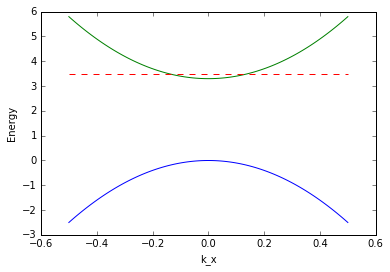

In [30]:
k = np.linspace(-0.5,0.5,100)
k = np.stack([k,np.zeros(len(k)),np.zeros(len(k))],axis=1)

plt.xlabel('k_x')
plt.ylabel('Energy')

for i, band_info in enumerate(bands):
    band_energies = band(k, band_info[2], band_info[1], band_info[0])
    
    plt.plot(k[:,0],band_energies)
plt.plot([-0.5,0.5],[fermiEnergy,fermiEnergy],'--')
plt.show()

# Calculate histogram


In [36]:
eBin = np.linspace(3,7,80)

In [32]:
EELS = spectrum.calculate_spectrum((mesh,k_list,e_arr,w_arr),eBin,fermiEnergy)


In [ ]:
EELS_smooth = smooth(EELS, eBin, 0.02) #smoothing of data

(3, 1, 1, 1)


In [ ]:
spectrum.saveHyperspy(filename="direct_fermi02",data=EELS_smooth,eBin=eBin,mesh=mesh)